In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import theano
import matplotlib
from matplotlib import pyplot
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
log = logging.getLogger()
log.setLevel('DEBUG')
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5005)
/home/schirrmr/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load data as in paper

In [2]:
C_sensors = ['FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h',
             'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
             'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h',
             'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
             'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h',
             'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
             'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h']
#C_sensors = ['C3', 'Cz', 'C4'] # for faster debugging
#load_sensor_names = None # we always did cleaning on full set to be able to compare different sensor montages fairly
# but to make it faster let's now not do this:
load_sensor_names = C_sensors

In [4]:
from braindecode.datasets.combined import CombinedCleanedSet

from braindecode.mywyrm.processing import resample_cnt, bandpass_cnt, exponential_standardize_cnt

from braindecode.datasets.cnt_signal_matrix import CntSignalMatrix
from braindecode.datasets.signal_processor import SignalProcessor
from braindecode.datasets.loaders import BBCIDataset
train_filename = 'data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat'
test_filename = 'data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10_1-2BBCI.mat'

# trial ivan in milliseconds
# these are the samples that will be predicted, so for a 
# network with 2000ms receptive field
# 1500 means the first receptive field goes from -500 to 1500
segment_ival = [1500,4000]


train_loader = BBCIDataset(train_filename, load_sensor_names=load_sensor_names)
test_loader = BBCIDataset(test_filename, load_sensor_names=load_sensor_names)

# Preprocessing pipeline in [(function, {args:values)] logic
from wyrm.processing import select_channels
cnt_preprocessors = [
    (select_channels , {
        'invert': True, 
        'regexp_list': ['Cz']
    },),
    (resample_cnt , {'newfs': 250.0}),
    (bandpass_cnt, {
        'low_cut_hz': 0,
        'high_cut_hz': 250,
     }),
     (exponential_standardize_cnt, {})
]

marker_def = {'1- Right Hand': [1],  '2 - Left Hand': [2], '3 - Rest': [3],
                                               '4 - Feet': [4]}

train_signal_proc = SignalProcessor(set_loader=train_loader, segment_ival=segment_ival,
                                   cnt_preprocessors=cnt_preprocessors,
                                   marker_def=marker_def)
train_set = CntSignalMatrix(signal_processor=train_signal_proc, sensor_names=C_sensors)

test_signal_proc = SignalProcessor(set_loader=test_loader, segment_ival=segment_ival,
                                   cnt_preprocessors=cnt_preprocessors,
                                   marker_def=marker_def)
test_set = CntSignalMatrix(signal_processor=test_signal_proc, sensor_names=C_sensors)

from braindecode.mywyrm.clean import MaxAbsCleaner
train_cleaner = MaxAbsCleaner(segment_ival=[0,4000], threshold=800, marker_def=marker_def)
test_cleaner = MaxAbsCleaner(segment_ival=[0,4000], threshold=800, marker_def=marker_def)
combined_set = CombinedCleanedSet(train_set, test_set,train_cleaner, test_cleaner)


In [7]:
combined_set.load()

2017-04-27 20:34:32,807 Load Training Set...
2017-04-27 20:34:44,131 Load Test Set...
2017-04-27 20:34:46,255 Clean Training Set...
2017-04-27 20:34:46,859 Rejected channels: []
2017-04-27 20:34:46,860 #Clean trials:     895
2017-04-27 20:34:46,861 #Rejected trials:  2
2017-04-27 20:34:46,862 Fraction Clean:    99.0%
2017-04-27 20:34:46,863 (from maxmin):     2
2017-04-27 20:34:46,864 (from var):        0
2017-04-27 20:34:46,998 Clean Test Set...
2017-04-27 20:34:47,098 Rejected channels: []
2017-04-27 20:34:47,100 #Clean trials:     160
2017-04-27 20:34:47,101 #Rejected trials:  0
2017-04-27 20:34:47,101 Fraction Clean:    100.0%
2017-04-27 20:34:47,102 (from maxmin):     0
2017-04-27 20:34:47,103 (from var):        0
2017-04-27 20:34:47,104 Create Cleaned Cnt Sets...
2017-04-27 20:34:47,995 Create sets from cleaned cnt...
2017-04-27 20:34:47,996 Preprocess continuous signal...
2017-04-27 20:34:59,460 Not doing any bandpass, since low 0 or None and high None or current fs
2017-04-27 2

### define the model

In [8]:
from braindecode.models.deep5 import Deep5Net
from braindecode.veganlasagne.layer_util import print_layers
from lasagne.nonlinearities import elu,softmax,identity
from numpy.random import RandomState
import lasagne
in_chans = train_set.get_topological_view().shape[1]
input_time_length = 1000 # implies how many crops are processed in parallel, does _not_ determine receptive field size
# receptive field size is determined by model architecture
num_filters_time = 25
filter_time_length = 10
num_filters_spat = 25
pool_time_length = 3
pool_time_stride = 3
num_filters_2 = 50
filter_length_2 = 10
num_filters_3 = 100
filter_length_3 = 10
num_filters_4 = 200
filter_length_4 = 10
final_dense_length = 2
n_classes = 4
final_nonlin=softmax
first_nonlin=elu
first_pool_mode='max',
first_pool_nonlin=identity
later_nonlin=elu
later_pool_mode='max'
later_pool_nonlin=identity
drop_in_prob=0.0
drop_prob=0.5
batch_norm_alpha=0.1
double_time_convs=False
split_first_layer=True
batch_norm=True
# ensure reproducibility by resetting lasagne/theano random generator
lasagne.random.set_rng(RandomState(34734))

d5net = Deep5Net(in_chans=in_chans, input_time_length=input_time_length, num_filters_time=num_filters_time,
         filter_time_length=filter_time_length,
         num_filters_spat=num_filters_spat, pool_time_length=pool_time_length, pool_time_stride=pool_time_stride,
         num_filters_2=num_filters_2, filter_length_2=filter_length_2,
         num_filters_3=num_filters_3, filter_length_3=filter_length_3,
         num_filters_4=num_filters_4, filter_length_4=filter_length_4,
         final_dense_length=final_dense_length, n_classes=n_classes,
         final_nonlin=final_nonlin, first_nonlin=first_nonlin,
         first_pool_mode='max', first_pool_nonlin=first_pool_nonlin,
         later_nonlin=later_nonlin, later_pool_mode='max', later_pool_nonlin=later_pool_nonlin,
         drop_in_prob=drop_in_prob, drop_prob=drop_prob, batch_norm_alpha=batch_norm_alpha,
         double_time_convs=double_time_convs,  split_first_layer=split_first_layer, batch_norm=batch_norm)
final_layer = d5net.get_layers()[-1]
print_layers(final_layer)

 0-InputLayer                                                         (None, 44, 1000, 1)
 1-DimshuffleLayer                                                    (None, 1, 1000, 44)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 44)
 4-Conv2DAllColsLayer       1x44                                      (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     elu            
12-Pool2DLayer          

### Define how to split into train/valid/Test and how to iterate over data

In [9]:
from braindecode.datahandling.splitters import SeveralSetsSplitter
dataset_splitter = SeveralSetsSplitter(valid_set_fraction=0.2, use_test_as_valid=False)
datasets = dataset_splitter.split_into_train_valid_test(combined_set)
from braindecode.datahandling.batch_iteration import CntWindowTrialIterator
from braindecode.veganlasagne.layers import get_n_sample_preds
iterator = CntWindowTrialIterator(batch_size=45,input_time_length=input_time_length,
                                 n_sample_preds=get_n_sample_preds(final_layer))

### Define loss, updates and compile train function

In [10]:
from braindecode.veganlasagne.update_modifiers import MaxNormConstraintWithDefaults
from lasagne.objectives import categorical_crossentropy
import lasagne
from lasagne.updates import adam
import theano.tensor as T

target_var = T.imatrix()
prediction = lasagne.layers.get_output(final_layer,
            deterministic=False)
        
# test as in during testing not as in "test set"
test_prediction = lasagne.layers.get_output(final_layer, 
    deterministic=True)
loss = categorical_crossentropy(prediction, target_var).mean()
test_loss = categorical_crossentropy(test_prediction, target_var).mean()

# create parameter update expressions
params = lasagne.layers.get_all_params(final_layer, trainable=True)
updates = adam(loss, params, learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-08)
# this will enforce maximum filter norm 2.0 for conv layers and 0.5 for final layer
updates = MaxNormConstraintWithDefaults({}).modify(updates, final_layer)

input_var = lasagne.layers.get_all_layers(final_layer)[0].input_var
# Store all parameters, including update params like adam params,
# needed for resetting to best model after early stop

# We need to remember both layer params
# and update params, update params contain trainable layer params + adam
# but miss the layer params that are not trainable like batch norm mean/std
all_layer_params = lasagne.layers.get_all_params(final_layer)
all_params = all_layer_params
# now params from adam would still be missing... add them ...
all_update_params = updates.keys()

for param in all_update_params:
    if param not in all_params:
        all_params.append(param)

train_func = theano.function([input_var, target_var], updates=updates)


2017-04-27 20:35:27,108 Constraining time_conv to norm 2.00
2017-04-27 20:35:27,113 Constraining spat_conv to norm 2.00
2017-04-27 20:35:27,118 Constraining combined_conv_2 to norm 2.00
2017-04-27 20:35:27,122 Constraining combined_conv_3 to norm 2.00
2017-04-27 20:35:27,125 Constraining combined_conv_4 to norm 2.00
2017-04-27 20:35:27,129 Constraining final_dense to norm 0.50


### Define monitors (that will monitor training progress)

In [11]:
from braindecode.veganlasagne.monitors import CntTrialMisclassMonitor, LossMonitor, RuntimeMonitor
from braindecode.veganlasagne.monitors import MonitorManager
monitors = [LossMonitor(), CntTrialMisclassMonitor(input_time_length=input_time_length), RuntimeMonitor()]


monitor_manager = MonitorManager(monitors)

# Create prediction and loss functions needed for monitoring
monitor_manager.create_theano_functions(input_var, target_var,
            test_prediction, test_loss)

In [12]:
from collections import OrderedDict
monitor_chans = OrderedDict()
monitor_manager.setup(monitor_chans,datasets)

### Train until early stop, remember best params

In [13]:
def print_epoch(monitor_chans):
        # -1 due to doing one monitor at start of training
        i_epoch = len(monitor_chans.values()[0]) - 1 
        log.info("Epoch {:d}".format(i_epoch))
        for chan_name in monitor_chans:
            log.info("{:25s} {:.5f}".format(chan_name,
                monitor_chans[chan_name][-1]))
        log.info("")

In [14]:
monitor_manager.monitor_epoch(monitor_chans, datasets, iterator)

print_epoch(monitor_chans)

2017-04-27 20:35:43,298 Epoch 0
2017-04-27 20:35:43,300 train_loss                1.40141
2017-04-27 20:35:43,301 valid_loss                1.40704
2017-04-27 20:35:43,302 test_loss                 1.41093
2017-04-27 20:35:43,303 train_misclass            0.78483
2017-04-27 20:35:43,304 valid_misclass            0.81111
2017-04-27 20:35:43,305 test_misclass             0.84375
2017-04-27 20:35:43,305 runtime                   0.00000
2017-04-27 20:35:43,306 


In [15]:
from braindecode.veganlasagne.remember import RememberBest
rememberer = RememberBest('valid_misclass')
rememberer.remember_epoch(monitor_chans, all_params)

2017-04-27 20:35:43,345 New best valid_misclass: 0.811111


### Define stop criterion and run

In [16]:
from braindecode.veganlasagne.stopping import MaxEpochs, NoDecrease, Or
#debug: n_no_decrease_max_epochs = 2
#debug: n_max_epochs = 4
n_no_decrease_max_epochs = 20
n_max_epochs = 100
# real values for paper were 80 and 800
stop_criterion = Or([NoDecrease('valid_misclass', num_epochs=n_no_decrease_max_epochs),
                     MaxEpochs(num_epochs=n_max_epochs)])

In [17]:
from time import time
def train_one_epoch(datasets, iterator, train_func):
    batch_generator = iterator.get_batches(datasets['train'], shuffle=True)
    for inputs, targets in batch_generator:
        if len(inputs) > 0:
            train_func(inputs, targets)

In [18]:
iterator.reset_rng()
while not stop_criterion.should_stop(monitor_chans):
    train_one_epoch(datasets, iterator, train_func)
    monitor_manager.monitor_epoch(monitor_chans, datasets, iterator)
    print_epoch(monitor_chans)
    rememberer.remember_epoch(monitor_chans, all_params)

2017-04-27 20:35:52,547 Epoch 1
2017-04-27 20:35:52,549 train_loss                0.99773
2017-04-27 20:35:52,550 valid_loss                1.02252
2017-04-27 20:35:52,550 test_loss                 1.05205
2017-04-27 20:35:52,551 train_misclass            0.37313
2017-04-27 20:35:52,552 valid_misclass            0.37778
2017-04-27 20:35:52,553 test_misclass             0.44375
2017-04-27 20:35:52,554 runtime                   9.26076
2017-04-27 20:35:52,555 
2017-04-27 20:35:52,558 New best valid_misclass: 0.377778
2017-04-27 20:36:01,636 Epoch 2
2017-04-27 20:36:01,638 train_loss                1.31655
2017-04-27 20:36:01,639 valid_loss                1.50395
2017-04-27 20:36:01,640 test_loss                 1.56170
2017-04-27 20:36:01,641 train_misclass            0.42289
2017-04-27 20:36:01,641 valid_misclass            0.51111
2017-04-27 20:36:01,642 test_misclass             0.55625
2017-04-27 20:36:01,643 runtime                   9.10874
2017-04-27 20:36:01,644 
2017-04-27 20:36

### reset params etc. for training after early stop

In [19]:
from copy import deepcopy
from braindecode.veganlasagne.stopping import ChanBelow

old_monitor_chans = deepcopy(monitor_chans)
rememberer.reset_to_best_model(monitor_chans,all_params)
loss_to_reach = monitor_chans['train_loss'][-1]
# we stop now if valid loss (valid is being trained on now!) goes below training loss from before
# or if we have trained already same number of epochs again as until early stop
stop_criterion = Or(stop_criteria=[
    MaxEpochs(num_epochs=rememberer.best_epoch * 2),
    ChanBelow(chan_name='valid_loss', target_value=loss_to_reach)])


#### create new dataset, merge valid back into train fold

In [20]:
from braindecode.datahandling.splitters import get_merged_train_valid_test

datasets = get_merged_train_valid_test(combined_set,dataset_splitter, preprocessor=None)

In [21]:
monitor_manager.monitor_epoch(monitor_chans, datasets, iterator)

print_epoch(monitor_chans)

2017-04-27 20:41:29,834 Epoch 33
2017-04-27 20:41:29,835 train_loss                0.04580
2017-04-27 20:41:29,836 valid_loss                0.13709
2017-04-27 20:41:29,837 test_loss                 0.19555
2017-04-27 20:41:29,837 train_misclass            0.00112
2017-04-27 20:41:29,838 valid_misclass            0.01111
2017-04-27 20:41:29,839 test_misclass             0.04375
2017-04-27 20:41:29,840 runtime                   3.82344
2017-04-27 20:41:29,841 


In [22]:
iterator.reset_rng()
while not stop_criterion.should_stop(monitor_chans):
    train_one_epoch(datasets, iterator, train_func)
    monitor_manager.monitor_epoch(monitor_chans, datasets, iterator)
    print_epoch(monitor_chans)

2017-04-27 20:41:40,354 Epoch 34
2017-04-27 20:41:40,356 train_loss                0.04603
2017-04-27 20:41:40,357 valid_loss                0.11631
2017-04-27 20:41:40,359 test_loss                 0.22169
2017-04-27 20:41:40,360 train_misclass            0.00112
2017-04-27 20:41:40,361 valid_misclass            0.01111
2017-04-27 20:41:40,362 test_misclass             0.04375
2017-04-27 20:41:40,362 runtime                   10.44520
2017-04-27 20:41:40,363 
2017-04-27 20:41:50,947 Epoch 35
2017-04-27 20:41:50,949 train_loss                0.03929
2017-04-27 20:41:50,950 valid_loss                0.07867
2017-04-27 20:41:50,950 test_loss                 0.14377
2017-04-27 20:41:50,951 train_misclass            0.00000
2017-04-27 20:41:50,952 valid_misclass            0.00000
2017-04-27 20:41:50,953 test_misclass             0.01250
2017-04-27 20:41:50,954 runtime                   10.57616
2017-04-27 20:41:50,955 
2017-04-27 20:42:01,524 Epoch 36
2017-04-27 20:42:01,526 train_loss   

### lets look at combined weights from first split layer

In [23]:
# Combine the weights. We have to reverse them with ::-1 to change convolution to cross-correlation
temporal_weights = params[0].get_value()[:,:,::-1,::-1]
spat_filt_weights = params[2].get_value()[:,:,::-1,::-1]

combined_weights = np.tensordot(spat_filt_weights, temporal_weights, axes=(1,0))

combined_weights = combined_weights.squeeze()

### One example weight

3 Peaks in 40 ms -> 3 * 1000 / 40 = 75 Hz -> Gamma ? :D

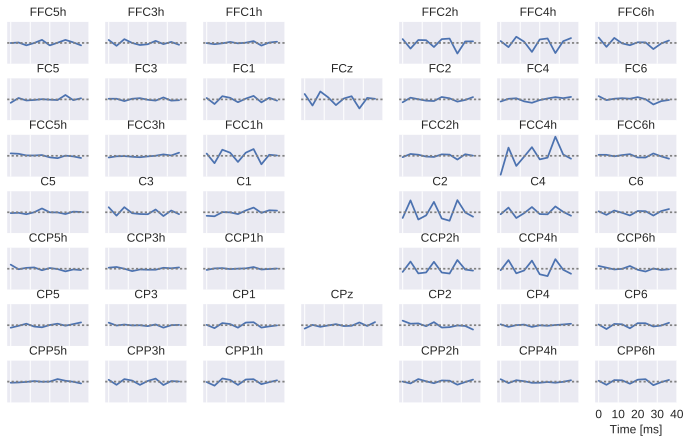

In [25]:
from braindecode.analysis.plot_util import plot_head_signals_tight
import matplotlib.pyplot as plt
plot_head_signals_tight(combined_weights[2], train_set.sensor_names, sharex=False)
xticks = np.linspace(0,10,5, endpoint=True)
xlabels = np.int32(1000 * xticks / 250.0)
plt.xticks(xticks, xlabels, fontsize=12)
plt.xlabel('Time [ms]', fontsize=12)
for ax in plt.gcf().axes[:-1]:
    ax.set_xticks(xticks)
    ax.set_xticklabels([''] * len(xticks))
None

### Training curves - loss and misclass

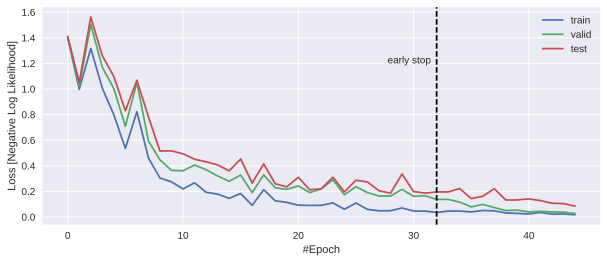

In [57]:
plt.figure(figsize=(10,4))
plt.plot(monitor_chans['train_loss'])
plt.plot(monitor_chans['valid_loss'])
plt.plot(monitor_chans['test_loss'])
plt.legend(('train', 'valid', 'test'))
plt.xlabel("#Epoch")
plt.ylabel("Loss [Negative Log Likelihood]")
# also put indication of early stop
plt.axvline(x=rememberer.best_epoch, color='black', linestyle='--', label='hi')
plt.annotate('early stop', (rememberer.best_epoch - 0.5, 1.2), fontsize=10, ha='right')

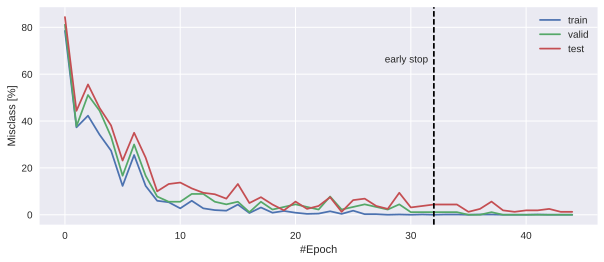

In [58]:
plt.figure(figsize=(10,4))

plt.plot(np.array(monitor_chans['train_misclass']) * 100)
plt.plot(np.array(monitor_chans['valid_misclass']) * 100)
plt.plot(np.array(monitor_chans['test_misclass']) * 100)
plt.xlabel("#Epoch")
plt.ylabel("Misclass [%]")
# also put indication of early stop
plt.axvline(x=rememberer.best_epoch, color='black', linestyle='--', label='hi')
plt.legend(('train', 'valid', 'test'))

plt.annotate('early stop', (rememberer.best_epoch - 0.5, 65), fontsize=10, ha='right')

### Save model params

Note that this is nto a complete snapshot of the experiment, for that you would also need to save the current adam values (current running means and running means of squared values of gradients)

In [60]:
np.save('tutorial-movement-model-params.npy', lasagne.layers.get_all_param_values(final_layer))

## Stuff just for me (Robin) :)

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'